## Example of the autoblock usage

Computational graphs in bosk requires their nodes to be a `BaseBlock` instances. To make user models including easier, the `auto_block` decorator was developed. Using it, you can easily convert your custom model to the `BaseBlock`. To get examples of converting scikit-learn interface models, see the `bosk.block.zoo.models.classification` subpackage code.

In [1]:
from bosk.block.auto import auto_block
from bosk.block.meta import BlockExecutionProperties
from bosk.executor.parallel.greedy import GreedyParallelExecutor
from bosk.painter.graphviz import GraphvizPainter
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from bosk.stages import Stage
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from IPython.display import Image

Consider we have the following model:

In [2]:
@auto_block(
    execution_props=BlockExecutionProperties(cpu=False, gpu=True, plain=False, threadsafe=True),
    random_state_field=None,
)
class NeuralNetwork(torch.nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.device = torch.device('cuda')
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(dim, dim * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 10, dim),
            torch.nn.Tanh(),
            torch.nn.Linear(dim, 1),
            torch.nn.Sigmoid()
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.nn.parameters(), 0.0005)
        self.batch_size = 64
        self.epochs_num = 500
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def _get_tensor(self, x: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(x.astype(np.float32)).to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proba = self.nn(x)
        return torch.concat((1 - proba, proba), dim=-1)

    def transform(self, x: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            x = self._get_tensor(x)
            return self(x).cpu().numpy()

    def fit(self, x: np.ndarray, y: np.ndarray) -> 'NeuralNetwork':
        x_tens = self._get_tensor(x)
        y_tens = self._get_tensor(y).long()
        dataset = TensorDataset(x_tens, y_tens)
        data_loader = DataLoader(dataset, self.batch_size, True)
        self.train()
        for _ in range(self.epochs_num):
            for x, y in data_loader:
                self.optimizer.zero_grad()
                pred = self(x)
                loss = self.loss_fn(pred, y)
                loss.backward()
                self.optimizer.step()
        return self

Let's describe what is happening here. We've got a Pytorch neural network model which we want to include in some bosk pipeline and train it on a GPU. To turn our model into a bosk `BaseBlock` we need to use `auto_block` decorator. 

The decorator works with the classes having `fit` and `transform` methods. It uses the methods' arguments names to create slots metainformation. Each argument name creates its own slot. If an argument is presented in the `fit` method, than the slot will be marked as used on the FIT stage. The same with the `transform` method and the TRANSFORM stage.

We can use `auto_block` without any arguments, and it will create a default CPU block with the default behaviour, which you can learn from the documentation. In our case we want this block to be marked to be runnable on the GPU (`cpu=False, gpu=True`), able to be parallelized (`thread_safe=True`), and as we didn't implement neural network weights initialization according to the given random seed, we marked `random_state_field=None` to do nothing in the `block.set_random_state` method.

Now let's make a pipeline with our model. Notice that we need to register our custom block in the functional builder. Also, it is needed to say that currently in `bosk` GPU data is stored using jax arrays, which are incompatible with the Pytorch tensors. This is why we didn't put any `MoveToBlock` in the pipeline and implemented all the data transfer logic inside of the `NeuralNetwork` model.

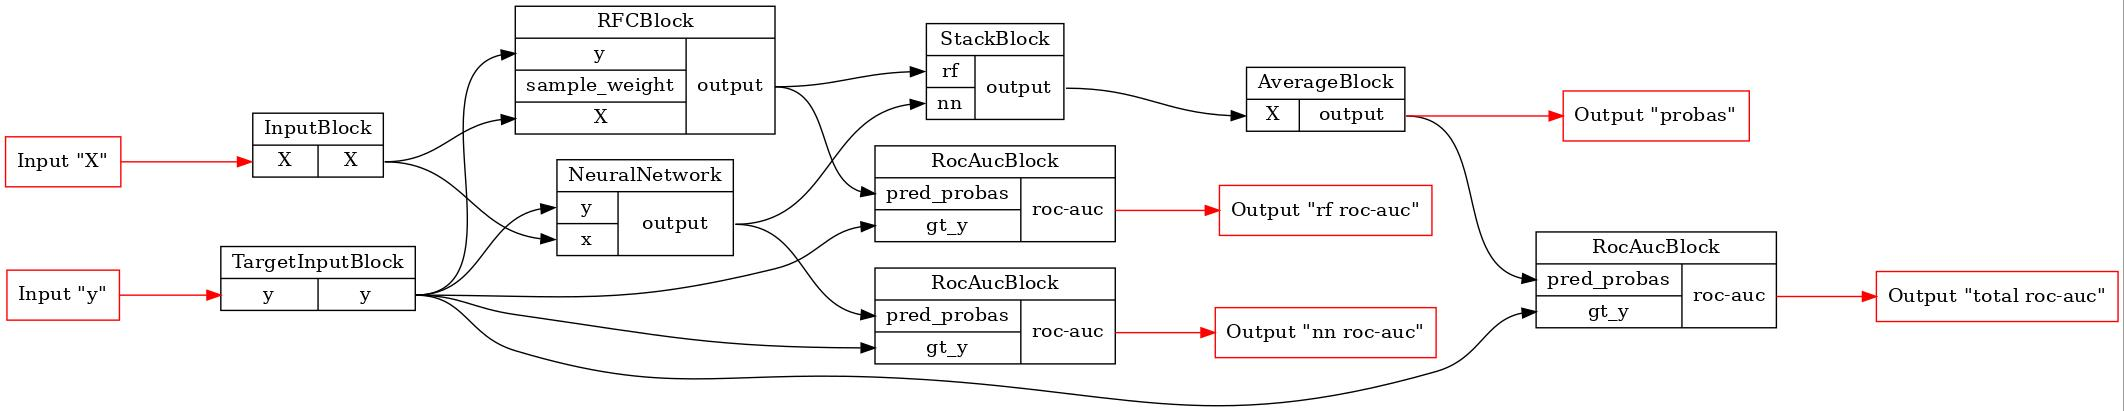

In [3]:
dim = 2

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf = b.RFC()(X=X, y=y)
rf_roc_auc = b.RocAuc()(gt_y=y, pred_probas=rf)

# block registration
nn_func_block_wrapper = b.new(NeuralNetwork, dim=dim)
# adding our block in the pipeline
nn = nn_func_block_wrapper(x=X, y=y)

nn_roc_auc = b.RocAuc()(gt_y=y, pred_probas=nn)
stack = b.Stack(['rf', 'nn'], axis=1)(rf=rf, nn=nn)
average = b.Average(axis=1)(X=stack)
roc_auc = b.RocAuc()(gt_y=y, pred_probas=average)
pipeline = b.build(
    {'X': X, 'y': y},
    {'probas': average, 'rf roc-auc': rf_roc_auc, 'total roc-auc': roc_auc, 'nn roc-auc': nn_roc_auc}
)
GraphvizPainter(figure_dpi=100).from_pipeline(pipeline).render('pipeline.jpeg')
display(Image('pipeline.jpeg'))

Now let's fit the pipeline in the parallel mode and see if our ensemble model brought some improvement to the basic models.

In [4]:
x, y = make_moons(200, noise=0.5)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.5)
train_data = {'X': train_x, 'y': train_y}
test_data = {'X': test_x, 'y': test_y}

fit_exec = GreedyParallelExecutor(pipeline, Stage.FIT, outputs=['rf roc-auc', 'nn roc-auc', 'total roc-auc'])
fit_res = fit_exec(train_data).numpy()
for key, val in fit_res.items():
    print(f'{key}:', round(val, 3))

rf roc-auc: 1.0
total roc-auc: 0.985
nn roc-auc: 0.923


In [5]:
test_exec = GreedyParallelExecutor(pipeline, Stage.TRANSFORM, outputs=['rf roc-auc', 'nn roc-auc', 'total roc-auc'])
test_res = test_exec(test_data).numpy()
for key, val in test_res.items():
    print(f'{key}:', round(val, 3))

rf roc-auc: 0.838
total roc-auc: 0.859
nn roc-auc: 0.891


As we can see, presented models aggregation helped us to improve classification quality.